In [57]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

from cgi_phasec_poppy import misc

from matplotlib.patches import Circle
from importlib import reload
reload(misc)

data_dir = Path('/groups/douglase/kians-data-files/disk-processing/')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf = 64
psf_pixelscale = 13e-6
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

polaxis = 10

ndisk = 128
disk_pixelscale_mas = 10.5*u.mas/u.pix
disk_pixelscale_lamD = (disk_pixelscale_mas/mas_per_lamD).value

band1_wavelength = 575e-9*u.m
iwa_band1 = 2.8
owa_band1 = 9.7

iwa = iwa_band1 * wavelength_c/band1_wavelength
owa = owa_band1 * wavelength_c/band1_wavelength

iwa_mas = iwa*mas_per_lamD
owa_mas = owa*mas_per_lamD

# Do the matrix multiplication

In [2]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_575_ipsfs_072022.hdf5'
f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

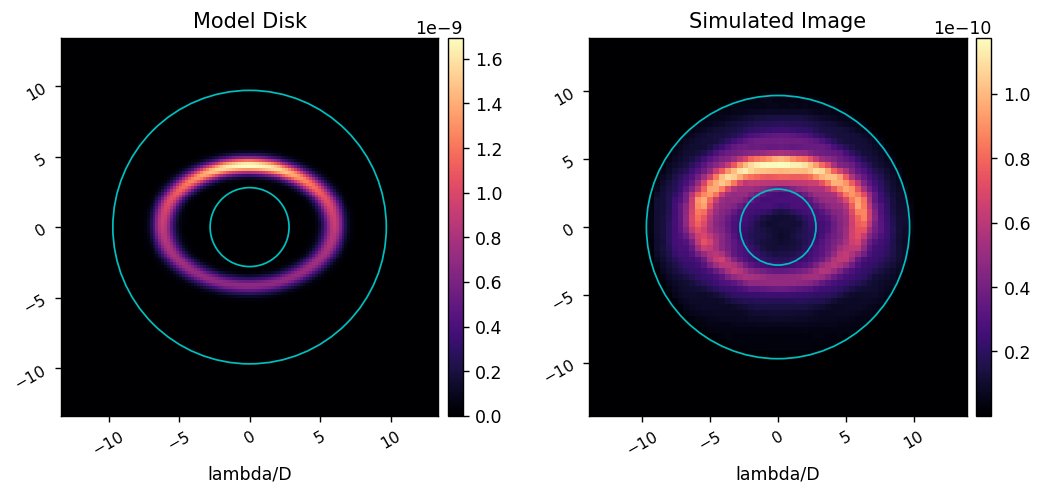

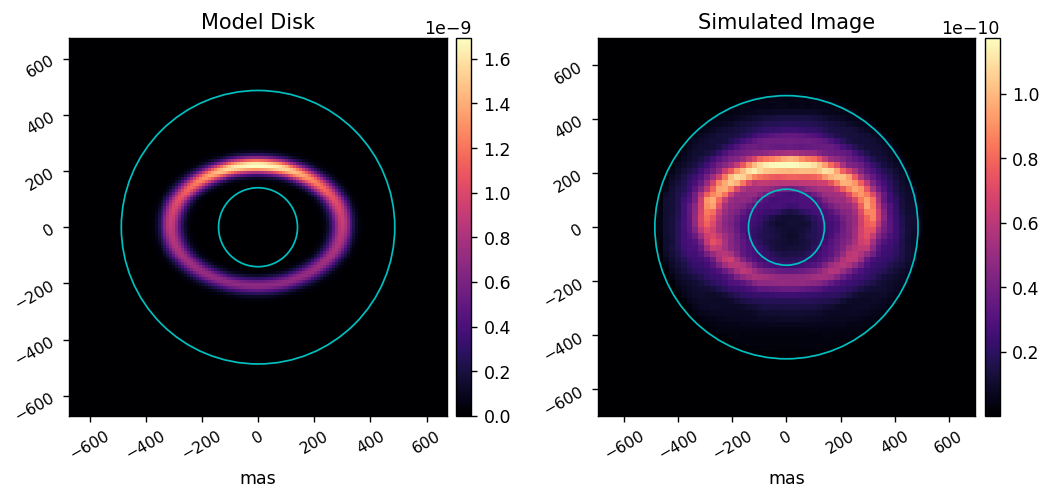

In [65]:
disk_fpath = data_dir/'disks'/'Debes_Models_07_2022'/'ring_inc45_r0.30.fits'
disk_hdr = fits.getheader(disk_fpath)

# disk = misc.pad_or_crop(fits.getdata(disk_fpath), ndisk), shift=-1, axis=1
disk = np.roll(misc.pad_or_crop(fits.getdata(disk_fpath), ndisk), shift=-1, axis=1)

disk_sim = np.reshape( ipsf_matrix.dot(disk.flatten()), (npsf,npsf)) 
disk_sim /= (psf_pixelscale_lamD/disk_pixelscale_lamD)**2

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim,
               'Model Disk', 'Simulated Image',
               lognorm1=False, lognorm2=False, 
               pxscl1=disk_pixelscale_lamD, pxscl2=psf_pixelscale_lamD, 
               patches1=patches1, patches2=patches2 )

patches1 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim,
               'Model Disk', 'Simulated Image',
               lognorm1=False, lognorm2=False, 
               pxscl1=disk_pixelscale_mas, pxscl2=psf_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

In [5]:
disk_hdr['PSCALE'], psf_pixelscale_mas, psf_pixelscale_mas.value/disk_hdr['PSCALE']

(10.4999998584, <Quantity 21.82142168 mas / pix>, 2.0782306638044514)

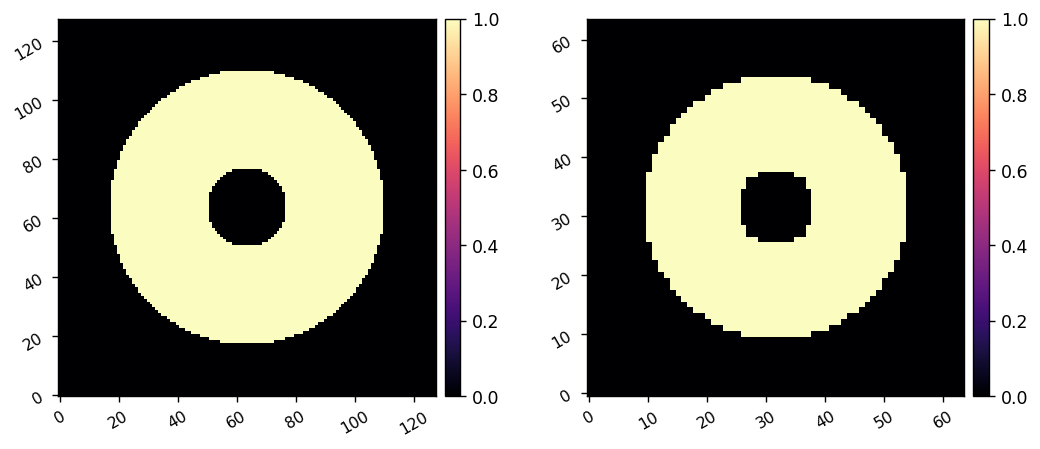

In [60]:
x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
xdisk = x*disk_pixelscale_lamD
ydisk = y*disk_pixelscale_lamD
rdisk = np.sqrt(xdisk**2 + ydisk**2)
disk_mask = ~((rdisk>owa) + (rdisk<iwa))

x,y = np.meshgrid(np.arange(-npsf/2,npsf/2) + 1/2, np.arange(-npsf/2,npsf/2)+1/2 )
xpsf = x*psf_pixelscale_lamD
ypsf = y*psf_pixelscale_lamD
rpsf = np.sqrt(xpsf**2 + ypsf**2)
psf_mask = ~((rpsf>owa) + (rpsf<iwa))

misc.myimshow2(disk_mask, psf_mask)

In [71]:
(disk*disk_mask).sum()

8.58269e-07

In [72]:
(disk_sim*psf_mask).sum()

4.238684847704607e-08

In [73]:
(disk_sim*psf_mask).sum()/(disk*disk_mask).sum()

0.04938643742710795

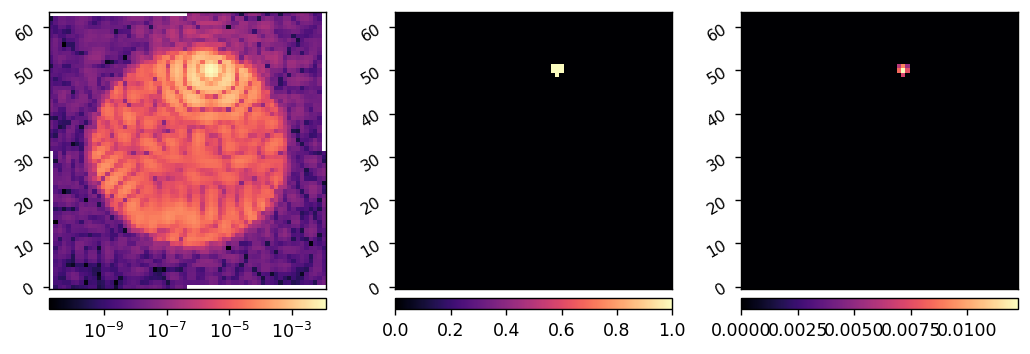

0.05598936901712542


In [70]:
psf = ipsf_matrix[:,13001].reshape(npsf,npsf)

ee_mask = psf>psf.max()/np.exp(1)

misc.myimshow3(psf, ee_mask, psf*ee_mask, lognorm1=True)

ee = (psf*ee_mask).sum()
print(ee)